In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import fasttext
import fasttext.util
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
es_vectors_100 = np.load('../data/processed/vector_es_100.npy',allow_pickle=True)
fr_vectors_100 = np.load('../data/processed/vector_fr_100.npy',allow_pickle=True)

In [3]:
sns.set_theme(style="dark")

def cosine_distance(u,v):
    return 1-cosine_similarity(u,v)

def cosine_minmax(u,v):
    similarity = cosine_similarity(u,v)
    scaler = MinMaxScaler()
    return scaler.fit_transform(similarity)

def cosine_maxabs(u,v):
    similarity = cosine_similarity(u,v)
    scaler = MaxAbsScaler()
    return scaler.fit_transform(similarity)

def cosine_square(u,v):
    return cosine_similarity(u,v)**2

def cosine_norm(u,v):
    S = cosine_similarity(u,v)
    Smin = S.min()
    Smax = S.max()
    return np.where(S<0, -S/Smin, S/Smax)

def cosine_arccos(u,v):
    S = 1-cosine_similarity(u,v)
    return np.arccos(S) / np.pi

def cosine_normalized(u,v):
    S = cosine_similarity(u,v)
    scaler = Normalizer()
    return scaler.fit_transform(S)

def cosine_robust(u,v):
    S = cosine_similarity(u,v)
    scaler = RobustScaler()
    return scaler.fit_transform(S)

def cosine_QT(u,v):
    S = cosine_similarity(u,v)
    scaler = QuantileTransformer(n_quantiles=3, output_distribution='normal')
    return scaler.fit_transform(S)

def cosine_PT(u,v):
    S = cosine_similarity(u,v)
    scaler = PowerTransformer(standardize=False)
    return scaler.fit_transform(S)

def cosine_inverse(u,v):
    return 1/(1-cosine_similarity(u,v))

def cosine_sqrt(u,v):
    return np.sqrt(np.abs(cosine_similarity(u,v)))

def cosine_alpha(u,v):
    return (np.abs(cosine_similarity(u,v)))**(1)

def cosine_inverse_exp(u,v):
    return 1/np.exp(1-cosine_similarity(u,v))

def cosine_robust_inverse(u,v):
    return 1/(1-cosine_robust(u,v))

def cosine_square_inverse(u,v):
    return 1/(1-cosine_square(u,v))

def cosine_upped(u,v):
    S = cosine_similarity(u,v)
    return (S-S.min())**2

def cosine_square_smoothed(u,v):
    S = cosine_similarity(u,v)
    return 1/(1-S)**4

def cosine_exp(u,v):
    S = 1-cosine_similarity(u,v)
    return np.exp(S**2)-1

def SPE_matrix(dim1,dim2,deg):
    if dim1>dim2:
        min_dim = dim2
        max_dim = dim1
        flip = True
    else:
        min_dim = dim1
        max_dim = dim2
        flip = False
    w_deg = (1/10000)**(deg/max_dim)
    basis = np.arange(max_dim)
    sep = np.cos( (basis - basis[:min_dim,None])*w_deg )
    if flip:
        return sep.T
    else:
        return sep

def cosine_SPE(u,v):
    spe = SPE_matrix(u.shape[0],v.shape[0],0)
    return spe

def cosine_transform(u,v):
    S = 1-cosine_similarity(u,v)
    for i in range(S.shape[0]):
        sigma_i = np.sqrt(np.var(S[i]))
        mean_i = np.mean(S[i])
        for j in range(S.shape[1]):
            mult = abs(S[i][j]-mean_i)/sigma_i
            if mult>1:
                S[i][j] = S[i][j]*mult
    return S

def outliers(u,v):
    S = 1-cosine_similarity(u,v)
    for i in range(S.shape[0]):
        sigma_i = np.std(S[i])
        mean_i = np.mean(S[i])
        born = mean_i - sigma_i
        for j in range(S.shape[1]):
            if S[i][j]>born:
                S[i][j] = S[i][j]
            else:
                S[i][j]=S[i][j]**2
    return S

def last_alpha(sample):
    alpha = 0
    into = []
    while(len(into)!=len(sample)):
        alpha+=1
        std = np.std(sample)
        mean = np.mean(sample)
        born = mean - alpha*std
        into = [x for x in sample if x > born]
    return alpha

def f_outliers(u,v):
    S = 1-cosine_similarity(u,v)
    for i in range(S.shape[0]):
        sigma_i = np.std(S[i])
        mean_i = np.mean(S[i])
        iqr =  stats.iqr(S[i])
        born = mean_i - sigma_i

        for j in range(S.shape[1]):
            S[i][j] = np.log(S[i][j] - (mean_i-last_alpha(S[i].tolist())*sigma_i))
    return S

def disc_square(u,v):
    S = 1-cosine_similarity(u,v)
    exp_S = np.zeros_like(S)
    for i in range(S.shape[0]):
        Q1 = np.percentile(S[i], 25)
        IQR = stats.iqr(S[i])
        for j in range(S.shape[1]):
            if S[i][j]<np.mean(S)-IQR:
                exp_S[i][j]=(S[i][j])**4/(np.mean(S)-IQR)**3
            else:
                exp_S[i][j]=S[i][j]
    return exp_S

def disc_exp(u,v):
    S = 1-cosine_similarity(u,v)
    exp_S = np.zeros_like(S)
    for i in range(S.shape[0]):
        Q1 = np.percentile(S[i], 25)
        IQR = stats.iqr(S[i])
        coef = (np.mean(S)-IQR)/(np.exp(np.mean(S)-IQR)-1)
        for j in range(S.shape[1]):
            if S[i][j]<np.mean(S)-IQR:
                exp_S[i][j]=(np.exp(S[i][j])-1)*coef
            else:
                exp_S[i][j]=S[i][j]
    return exp_S

all = [cosine_similarity, cosine_distance, cosine_minmax, cosine_maxabs, cosine_square, cosine_norm, cosine_arccos, 
cosine_normalized, cosine_robust, cosine_QT, cosine_PT, cosine_inverse, cosine_robust_inverse]

In [4]:
def evaluate(method, n_sentences, position):

    ids = []
    data = []
    for sentence_id in np.random.choice(5, n_sentences, replace=False).tolist():
        
        es_vector = np.asarray(es_vectors_100[sentence_id])
        fr_vector = np.asarray(fr_vectors_100[sentence_id])

        S = method(es_vector,fr_vector)
        ids = ids+[sentence_id]*(S.shape[0]*S.shape[1])
        data = data+ S.reshape(S.shape[0]*S.shape[1]).tolist()
    dict = {"sentence":ids,"similarity":data}
    df = pd.DataFrame(dict)
    if position!=None:
        sns.stripplot(data=df, x="sentence",y="similarity",ax=position)
        position.set_title(str(method).split(' ')[1])
    else:
        sns.stripplot(data=df, x="sentence",y="similarity")

def compare(methods,n_sentences=5):

    fig, axes = plt.subplots(1,len(methods), figsize=(25, 8))

    for i,method in enumerate(methods):
        evaluate(method, n_sentences, axes[i])
    
    fig.show()


/var/folders/2_/jyd0zmh173jbm_pwvmv8q3m40000gn/T/ipykernel_1150/4188220336.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


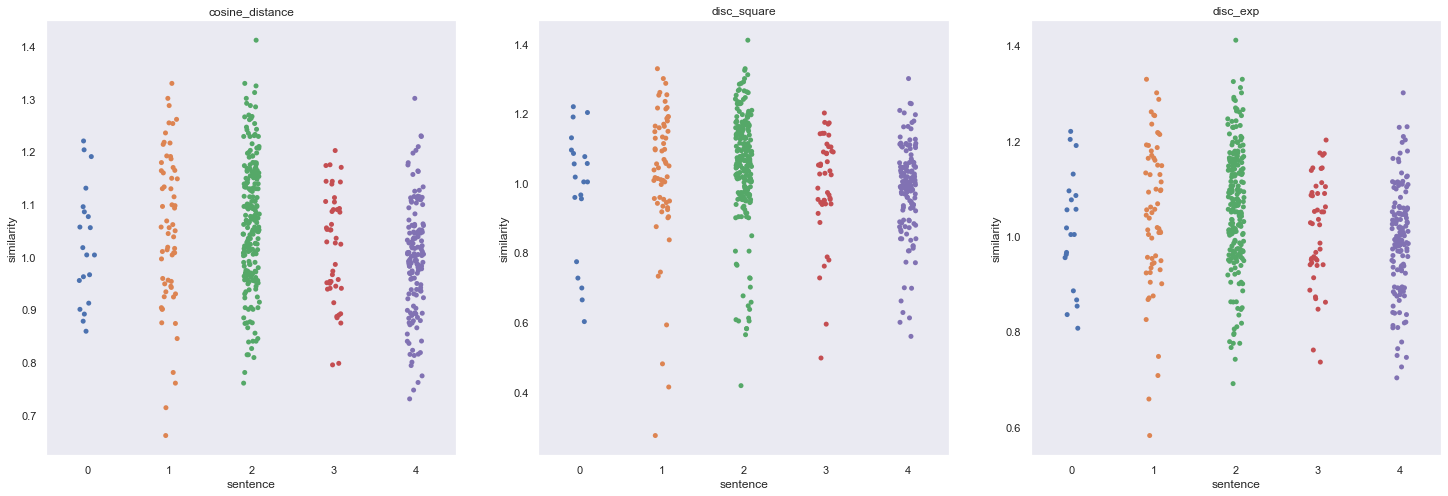

In [5]:
compare([cosine_distance, disc_square, disc_exp])